
#Assignment-#02
###Stereo Depth Estimation Using SIFT. Complete each question by implementing the required functions and code cells, following the instructions provided.



### Import Libraries


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Define Camera Parameters

In [2]:
#Given the focal length and baseline
focal_length = 4152.073
baseline =  176.252

### Load Stereo Images

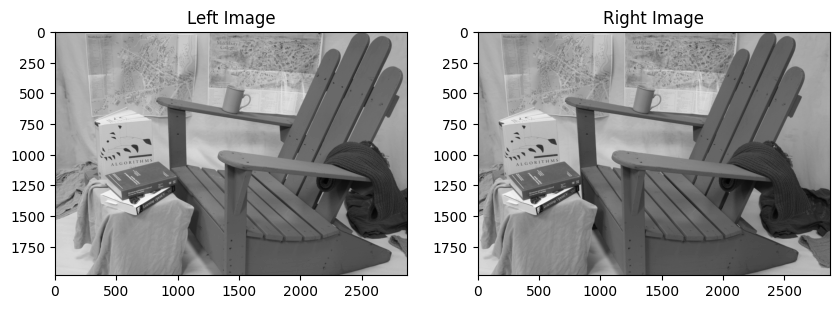

In [46]:
# Load left and right images
left_image = cv2.imread('./Images/im0.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('./Images/im1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
plt.show()

### Describe the differences you observe in the left and right images (2 Points)
The left image slightly shifts horizontally to the left compared to the right image, for which, we can observe that there are more pixels of floor and curtain in the left side of the left image than the right image.
The closer objects like books and chair appear to shift more between the two images than the farther objects like window and the cup on the arm of the chair. This disparity is the fundation of the estimation depth, the greater the shift, the closer the object to the camera.

In [24]:
def detect_and_match_features(left_image, right_image, ratio_test_threshold=0.7):
    """
    Detects and matches SIFT features between two images using FLANN-based matcher and Lowe's ratio test.

    Parameters:
    - left_image: Left image in stereo pair (grayscale).
    - right_image: Right image in stereo pair (grayscale).
    - ratio_test_threshold: Threshold for Lowe's ratio test to filter matches (default=0.7).

    Returns:
    - good_matches: List of good matches that passed the ratio test.
    - keypoints_left: Keypoints in the left image.
    - keypoints_right: Keypoints in the right image.
    - matched_image: Image showing matches between left and right images.
    """

    # Write your code will be here
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    keypoints_left, descriptors_left = sift.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(right_image, None)
    
    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    
    # create FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # flann = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

    # match descriptors
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
    
    # Lowe's ratio test to ensure the matches are robust
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test_threshold * n.distance:
            good_matches.append(m)
    # draw matches
    matched_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return good_matches,keypoints_left, keypoints_right, matched_image


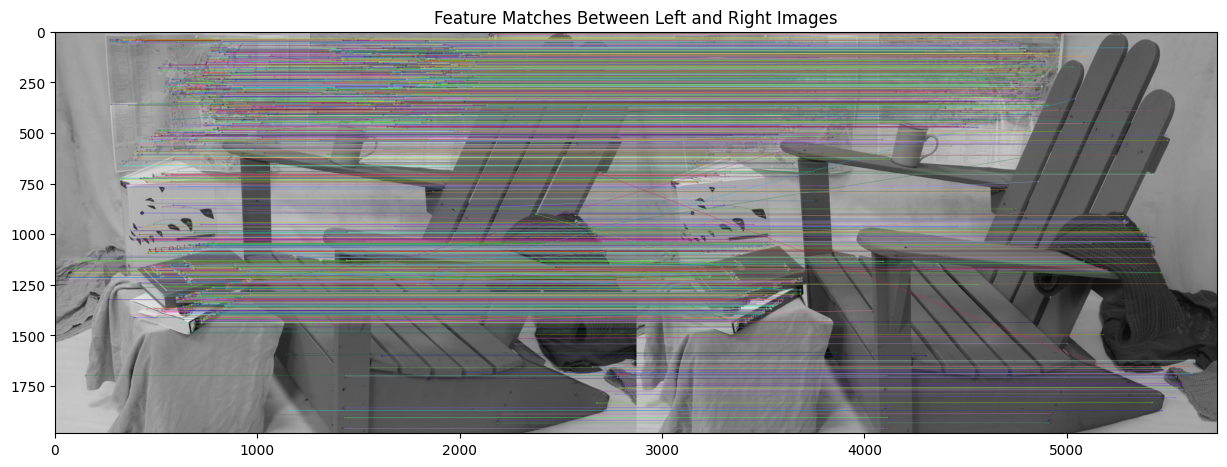

In [47]:
good_matches, keypoints_left, keypoints_right, matched_image = detect_and_match_features(left_image, right_image)

# Display the matched image
plt.figure(figsize=(15, 10))
plt.imshow(matched_image)
plt.title("Feature Matches Between Left and Right Images")
plt.show()


In [48]:
def calculate_disparity(keypoints_left, keypoints_right, good_matches, doffs=0):
    """
    Calculates the disparity between matched keypoints in left and right images.

    Parameters:
    - keypoints_left: Keypoints from the left image.
    - keypoints_right: Keypoints from the right image.
    - good_matches: List of good matches from feature matching.
    - doffs: Disparity offset (default is 0).

    Returns:
    - disparities: List of disparities for each matched keypoint pair.
    - xl_coords: List of x-coordinates in the left image for each matched keypoint pair.
    - xr_coords: List of x-coordinates in the right image for each matched keypoint pair.
    """

    # Write your code will be here

    disparities = []
    xl_coords = []
    xr_coords = []
    for match in good_matches:
        xl, yl = keypoints_left[match.queryIdx].pt
        xr, yr = keypoints_right[match.trainIdx].pt
        xl_coords.append(xl)
        xr_coords.append(xr)
        disparities.append(xl - xr - doffs)
    return disparities, xl_coords, xr_coords


 ### Display the disparity map

Sample x-coordinates in left image (xL): [58.030704498291016, 59.7195930480957, 62.041072845458984, 62.77497482299805, 63.42265701293945, 65.50032043457031, 69.33252716064453, 70.81547546386719, 72.09617614746094, 91.16959381103516]
Sample x-coordinates in right image (xR): [12.619818687438965, 14.108932495117188, 17.062583923339844, 17.036846160888672, 18.59267807006836, 20.279821395874023, 24.529495239257812, 26.108745574951172, 25.609493255615234, 45.60444641113281]
max disparity: 1968.4892272949219
min disparity: -1627.3113403320312
Non-zero disparities in map: 1925


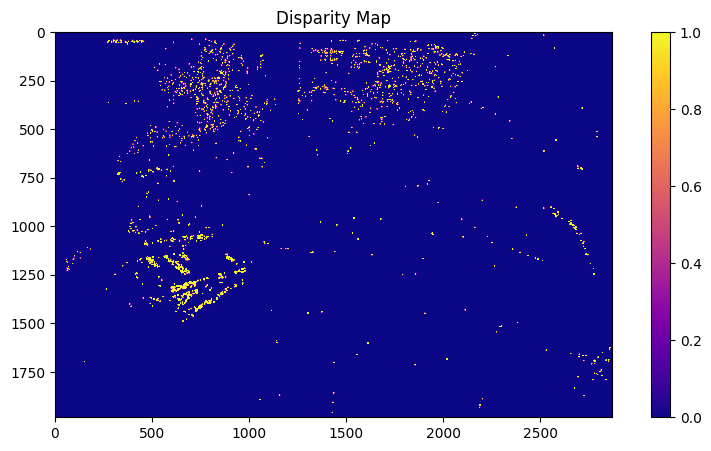

In [ ]:
from math import floor

disparity, xl_coords, xr_coords = calculate_disparity(keypoints_left, keypoints_right, good_matches)

print("Sample x-coordinates in left image (xL):", xl_coords[:10])
print("Sample x-coordinates in right image (xR):", xr_coords[:10])
print("max disparity:", max(disparity))
print("min disparity:", min(disparity))

disparity_map = np.zeros(left_image.shape[:2], dtype=np.float32)
for disparity_val, match in zip(disparity, good_matches):
    x, y = keypoints_left[match.queryIdx].pt
    x, y = int(np.floor(x)), int(np.floor(y))
    if 0 <= y < disparity_map.shape[0] and 0 <= x < disparity_map.shape[1]:
        disparity_map[y, x] = disparity_val

print("Non-zero disparities in map:", np.count_nonzero(disparity_map))
clipped_disparity_map = np.clip(disparity_map, 0, 255)
disparity_map_normalized = cv2.normalize(clipped_disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


plt.figure(figsize=(10, 5))
plt.imshow(disparity_map_normalized, cmap='plasma', vmin=0, vmax=1)
plt.colorbar()
plt.title("Disparity Map")
plt.show()



In [141]:
def calculate_depth_map(disparity_map, focal_length, baseline):
    """
    Calculates the depth map from a given disparity map, focal length, and baseline.

    Parameters:
    - disparity_map: 2D numpy array of disparities (same dimensions as the input images).
    - focal_length: Focal length of the camera in pixels.
    - baseline: Distance between the two camera centers in the stereo setup (in the same units as focal length).

    Returns:
    - depth_map: 2D numpy array representing depth for each pixel (same dimensions as disparity_map).
    """

    # Write your code will be here
    min_disparity = 1e-3
    disparity_map = np.maximum(disparity_map, min_disparity)
    depth_map = (focal_length * baseline) / disparity_map
    return depth_map


Depth map min: 0
Depth map max: 255


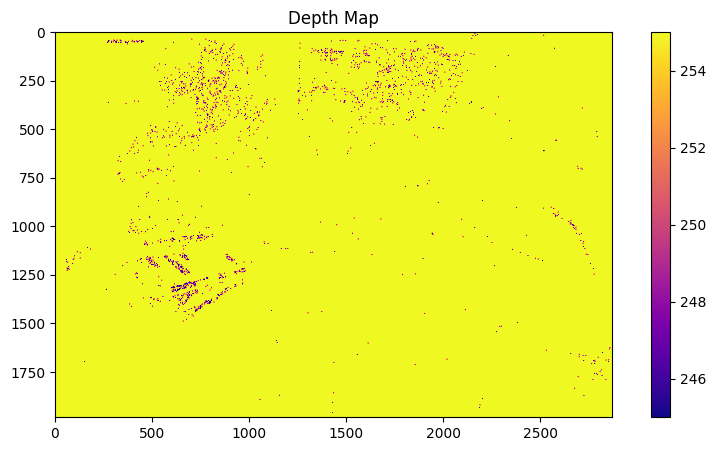

In [164]:
# Define camera parameters (as provided)
focal_length = 4152.073  # in pixels
baseline = 176.252       # in mm or the same unit

depth_map = calculate_depth_map(disparity_map, focal_length, baseline)
depth_map_normalized = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

print("Depth map min:", depth_map_normalized.min())
print("Depth map max:", depth_map_normalized.max())

# Display the depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map_normalized, cmap='plasma', vmin=245, vmax=255)
plt.colorbar()
plt.title("Depth Map")
plt.show()


### What does the disparity map represent? How does it relate to depth perception? Write the Mathematical Relationship (2 Points)

Disparity map represents the shifts in the positions of keypoints between the two stereo images. Which is inversely related to the depth, that means the depth would decrease if disparity increases. This relationship enables us to estimate the distance of object from camera based on the disparities.

The matematical relationship is:
$$
depth = \frac {focalLength \times baseline} {disparity}
$$
where the focal length is the same for two cameras and is in pixel, the baseline is the distance between two camera centers, and the disparity is in pixles. baseline and depth have the same unit.